This notebook explain each step in the processing pipeline in more details.

First, we still import and split data as usual

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

students = pd.read_csv('students_m5.csv')
students

,StudentID,FirstName,LastName,Major,HighSchoolGPA,FamilyIncome,State,AvgDailyStudyTime,TotalAbsence,FirstYearGPA,isGRA
0,202303595,Baxter,Dengler,Computer Science,2.82,45013,WA,2.01,14.0,1.93,0
1,202309162,Christian,Wickey,Data Science,3.07,128358,GA,5.41,NaN,2.76,0
2,202306337,Lonnie,Wulff,Software Engineering,2.68,112392,GA,9.57,13.0,3.09,0
3,202306072,Mitchell,Deshotel,Software Engineering,3.21,190846,GA,8.57,16.0,3.08,0
4,202301733,Linwood,Willing,Information Technology,3.44,187163,GA,6.24,20.0,2.73,0
...,...,...,...,...,...,...,...,...,...,...,...
995,202302372,Michael,Richman,Computer Science,4.00,32210,SC,8.84,16.0,3.31,1
996,202309892,Lacy,Anton,Software Engineering,3.02,163481,GA,6.61,17.0,2.53,0
997,202308310,Ell,Benke,Software Engineering,2.05,45446,GA,3.68,30.0,1.77,0
998,202305648,Elzie,Enderle,Information Technology,2.19,44714,GA,2.74,17.0,2.11,0


In [2]:
features = students.drop(['StudentID','FirstName','LastName','FirstYearGPA','isGRA'], axis=1)
labels = students['FirstYearGPA']

from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(features, labels, test_size=0.2)

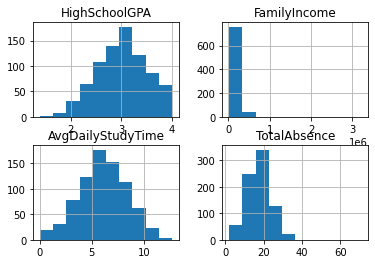

In [3]:
trainX.hist()
plt.show()

In [4]:
num_cols = ['HighSchoolGPA','FamilyIncome','AvgDailyStudyTime','TotalAbsence']
cat_cols = ['Major','State']

<h3>Pipeline Explained - Numeric Columns</h3>

As discussed, numeric and class columns undergo different transformations, so we process them with two pipelines.

Numeric columns will go through outlier removal, skewness removal, standardization, and imputation.

For removing outliers, we still use numpy.clip as in the previous module. 

This time, the function is applied on all numeric columns, so we add *axis=1* to indicate that. We further wrap the clipping inside a function so it is usable in a sklearn pipeline. The effect is exact as if we apply numpy.clip for each individual column manually as can be seen from the histograms.

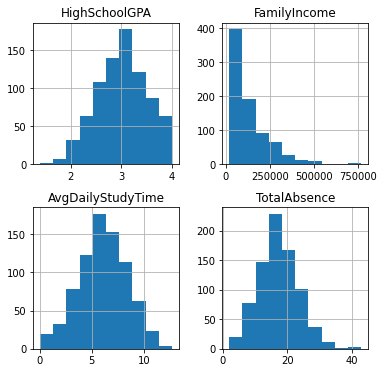

In [5]:
num_sds = trainX[num_cols].std()
num_means = trainX[num_cols].mean()

def outlier_clip(data):
    return np.clip(data, num_means - 4*num_sds, num_means + 4*num_sds, axis=1)

trainX_num = trainX[num_cols].copy()
trainX_num = outlier_clip(trainX_num)
trainX_num.hist(figsize=(6,6))
plt.show()

Similarly, log transformation is rewritten as a function extended to all numeric columns. The function returns both the original and log versions.

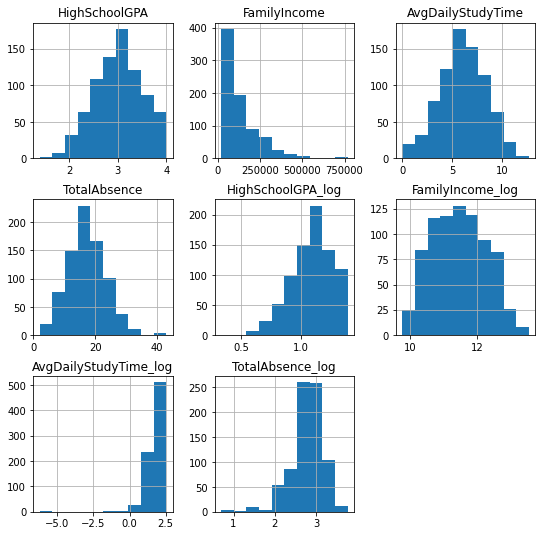

In [6]:
def log_transform(data):
    return pd.concat([data, np.log(data.add_suffix('_log') + 0.001)], axis=1)

trainX_num = log_transform(trainX_num+0.001)
trainX_num.hist(figsize=(9,9))
plt.show()

Instead of manually writing function, we can use StandardScaler from sklearn. This has the exactly same effect as manually subtracting the mean then dividing the data by their standard deviation.

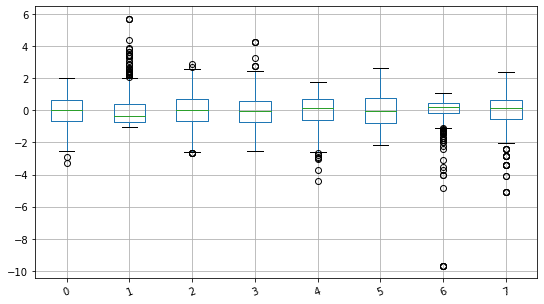

In [7]:
from sklearn.preprocessing import StandardScaler

trainX_num = StandardScaler().fit_transform(trainX_num)
pd.DataFrame(trainX_num).boxplot(figsize=(9,5),rot=20)
plt.show()

In [8]:
pd.DataFrame(trainX_num).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       800 non-null    float64
 1   1       800 non-null    float64
 2   2       787 non-null    float64
 3   3       794 non-null    float64
 4   4       800 non-null    float64
 5   5       800 non-null    float64
 6   6       787 non-null    float64
 7   7       794 non-null    float64
dtypes: float64(8)
memory usage: 50.1 KB


Finally, SimpleImputer is imported from sklearn and used to fill missing values. The argument 'median' indicates missing values will be replaced by their columns' medians.

In [9]:
from sklearn.impute import SimpleImputer

trainX_num = SimpleImputer().fit_transform(trainX_num, 'median')
pd.DataFrame(trainX_num).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       800 non-null    float64
 1   1       800 non-null    float64
 2   2       800 non-null    float64
 3   3       800 non-null    float64
 4   4       800 non-null    float64
 5   5       800 non-null    float64
 6   6       800 non-null    float64
 7   7       800 non-null    float64
dtypes: float64(8)
memory usage: 50.1 KB


<h3>Pipeline Explained - Categorical Columns </h3>

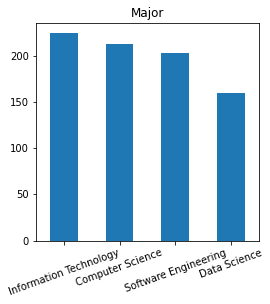

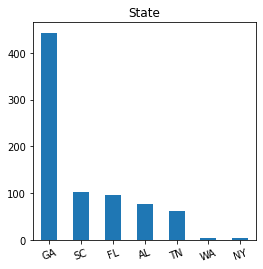

In [10]:
trainX_cat = trainX[cat_cols].copy()
for col in cat_cols:
    trainX_cat[col].value_counts().plot.bar(figsize=(4,4),rot=20)
    plt.title(col)
    plt.show()

Replacing rare values in class columns is a bit more complicated here. We want the process to be automated, so we will write a function that count the frequency of each class in a column, then removing classes with frequency below 40. You can modify this threshold to a different number if needed.

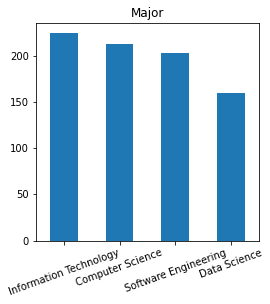

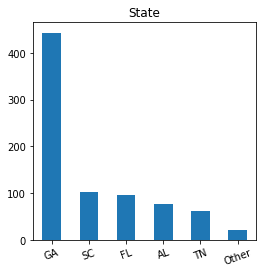

In [11]:
kept_classes = {}
for col in cat_cols:
    cat_counts = trainX_cat[col].value_counts()
    kept_classes[col] = cat_counts.index[cat_counts > 40]
    
def remove_rare_classes(data):
    data_copy = data.copy()
    for col in cat_cols:
        data_copy.loc[~data_copy[col].isin(kept_classes[col]), col] = 'Other'
    return data_copy

trainX_cat = remove_rare_classes(trainX_cat)

for col in cat_cols:
    trainX_cat[col].value_counts().plot.bar(figsize=(4,4),rot=20)
    plt.title(col)
    plt.show()

Encoding is easy as we will use OneHotEncoder from sklearn.

In [12]:
from sklearn.preprocessing import OneHotEncoder

trainX_cat = OneHotEncoder().fit_transform(trainX_cat)
trainX_cat

<800x10 sparse matrix of type '<class 'numpy.float64'>'
	with 1600 stored elements in Compressed Sparse Row format>